Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. Refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/benchmarks/mit_reactor.html) notebook for an in-depth tutorial. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# Heat Conduction

**Intputs**

- `qprime`: Linear heat generation rate ($\frac{W}{m}$)
- `mdot`: Mass flow rate ($\frac{g}{s}$)
- `Tin`: Temperature of the fuel boundary ($K$)
- `R`: Fuel radius ($m$)
- `L`: Fuel length ($m$)
- `Cp`: Heat capacity ($\frac{J}{g \cdot K}$)
- `k`: Thermal conductivity ($\frac{W}{m \cdot K}$)

**Output**

- `T`: Fuel centerline temperature ($K$)

This data set consists of 1000 points with seven inputs and one output. The data set was constructed through Latin hypercube sampling of the seven input parameters for heat conduction through a fuel rod. These samples were then used to solve for the fuel centerline temperature analytically. The geometry of the problem is illustrated in the figure below, and it is assumed volumetric heat generation is uniform radially. The problem is defined by

\begin{equation}
\frac{1}{r}\frac{d}{dr}(kr\frac{dT}{dr}) + q''' = 0,
\end{equation}

with two boundary conditions: $\frac{dT}{dr}|_{r = 0} = 0$ and $T(R) = T_{in}$. Therefore, the temperature profile in the fuel is

\begin{equation}
T(r) = \frac{q'}{4\pi k}(1 - (r / R)^2) + T_{in}.
\end{equation}

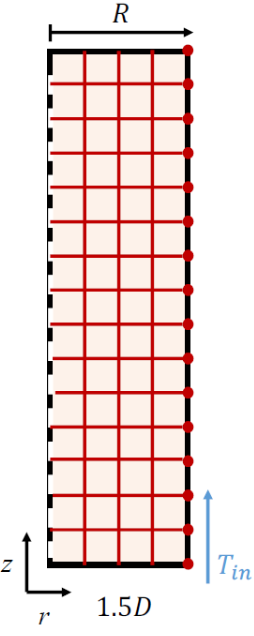

The following are a few standard packages and functions that will prove helpful while using pyMAISE along with pyMAISE-specific functionality. 

In [2]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_heat
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We start by initializing pyMAISE settings and then importing the data set using `pyMAISE.datasets.load_heat()` from the pyMAISE dataset library.

In [3]:
# Initializing pyMaise settings and the problem we are solving (regression)
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_heat()

The heat conduction data set has 7 inputs

In [4]:
inputs

<xarray.DataArray (index: 1000, variable: 7)>
array([[3.59879928e+04, 2.06185816e+02, 5.73151869e+02, ...,
        3.44815496e+00, 4.09614034e+00, 9.60945479e-01],
       [3.84810558e+04, 1.92378974e+02, 5.73150960e+02, ...,
        3.43683275e+00, 4.24918181e+00, 1.01127217e+00],
       [3.91432921e+04, 2.05076928e+02, 5.73153975e+02, ...,
        3.68145722e+00, 4.23754044e+00, 9.94646131e-01],
       ...,
       [4.01365078e+04, 1.91977771e+02, 5.73151522e+02, ...,
        3.63435094e+00, 4.12297685e+00, 1.01905766e+00],
       [4.06288682e+04, 1.93001960e+02, 5.73152035e+02, ...,
        3.64753610e+00, 4.21262950e+00, 9.68979168e-01],
       [3.90566005e+04, 1.87235532e+02, 5.73153905e+02, ...,
        3.40448532e+00, 4.06543435e+00, 1.00688469e+00]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'qprime' 'mdot' 'Tin' 'R' 'L' 'Cp' 'k'

and 1 output with 1000 data points.

In [5]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1034.13378385],
       [1170.31604229],
       [1164.89356528],
       [1205.25003976],
       [1444.71866607],
       [1415.16087218],
       [1141.02596298],
       [1135.41902917],
       [1087.37893848],
       [1484.62104894],
       [1095.53986907],
       [1173.29114652],
       [1157.14848053],
       [1256.81754162],
       [1118.14237521],
       [1042.34706612],
       [1049.5434326 ],
       [1181.84317152],
       [1425.17119154],
       [1201.11399329],
...
       [1440.68291936],
       [1126.62859092],
       [1118.47511015],
       [1215.64386477],
       [1506.41447337],
       [1118.13383746],
       [1427.1010686 ],
       [1070.54469832],
       [1393.14664198],
       [1374.22902546],
       [1142.38817778],
       [1487.82931858],
       [1103.84446468],
       [1161.70719007],
       [1503.51884631],
       [1396.11284268],
       [1570.4571551 ],
       [1438.29381922],
       [1374.74521282],
       [1187.64399672]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'T'

To better understand the data here is a correlation matrix of the data.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

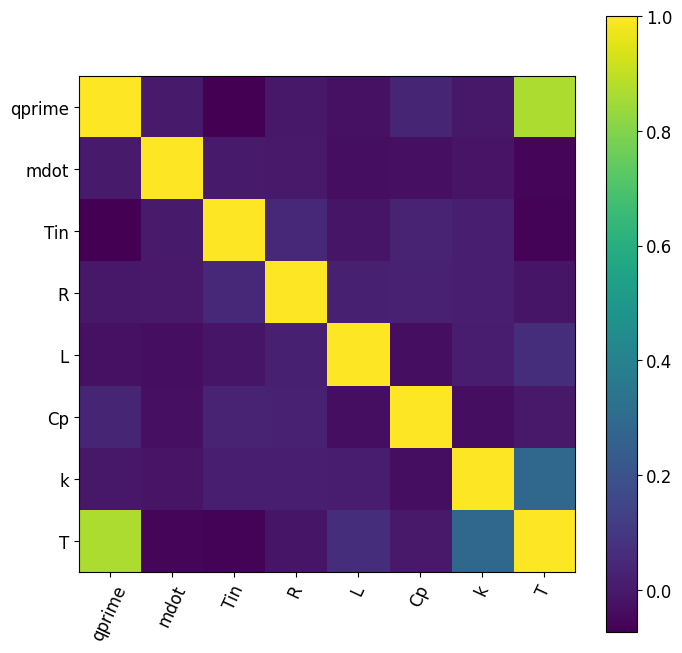

In [6]:
correlation_matrix(data)

As expected, there is a strong correlation between the linear heat generation rate, `prime,` and the centerline fuel temperature, `T.`

Before model training, the data is split into training/test (70% training and 30% testing) along with min-max scaling to make each feature's effect size comparable. Additionally, this can improve the performance of some models.

In [7]:
# Train test split data
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.30)

# Min-Max scaling data 
xtrain, xtest, _ = scale_data(xtrain, xtest, MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, MinMaxScaler())

## Model Initialization

We will examine the performance of 7 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Support vector regression: `SVM`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyperparameter tuning each model, we must initialize the architecture and optimize search spaces. For all the classical models we initialize them using the scikit-learn default configurations. The FNNs are defined as sequential dense neural networks. For the input and hidden dense layers we are hyperparameter tuning the number of nodes, sublayer, and sublayer dropout rate. We are also tuning the number of hidden layers, the Adam learning rate, and batch size.

In [8]:
# Initializing all the models wanted in the model)settings variable along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

For hyperparameter tuning the classical models, we use `pyMAISE.Tuner.random_search` with 300 iterations and 5-fold cross-validation. We do this because the classical models are relatively cheap to train, so we can better cover the hyperparameter search space. For the FNNs, we use `pyMAISE.Tuner.nn_bayesian_search` with 50 iterations and 5-fold cross-validation. We use Bayesian search with fewer configurations as the FNNs are more computationally expensive. The Bayesian search should converge on an optimal configuration within 30-50 iterations. The cross-validation ensures there is no bias in the configurations saved. The hyperparameter search spaces are outlined below.

In [9]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

# Running the tuner for with the search algorithm desired
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 09s]
r2_score: 0.8928644198368566

Best r2_score So Far: 0.9566222473338671
Total elapsed time: 00h 10m 06s
Hyperparameter tuning took 31.61695214907328 minutes to process.


With the conclusion of hyper-parameter tuning we can see the training results of each iteration of the bayesian search.

(0.0, 1.0)

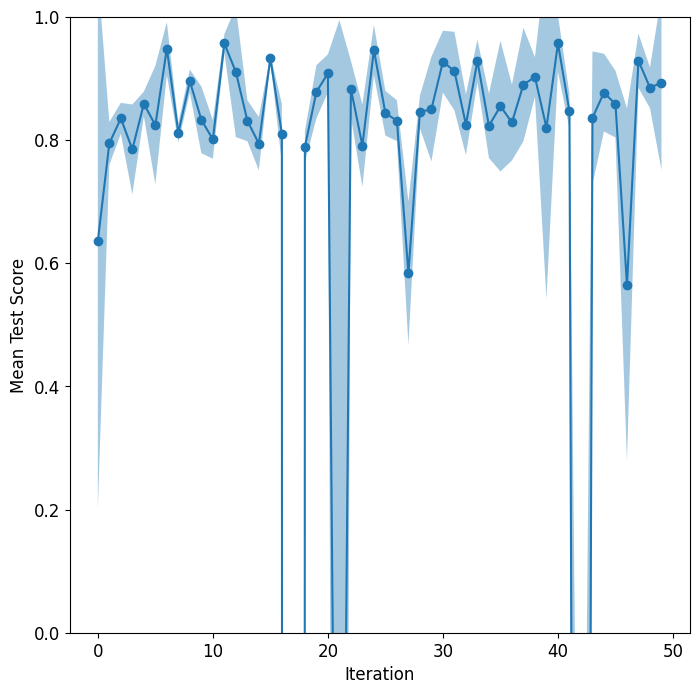

In [17]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

After about ten iterations, the Bayesian search converges on the optimal solution for this parameter space.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `FNN` models `epochs` for better performance.

In [24]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

The regression performance metrics on fuel centerline temperature are shown below.

In [25]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
20,RF,"{'criterion': 'squared_error', 'max_features':...",0.998011,4.588172,46.122117,6.791327,0.988605,10.175377,269.409414,16.413696
17,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.998134,4.397899,43.271212,6.578086,0.985662,9.983443,338.974617,18.411263
11,DT,"{'max_depth': 48, 'max_features': 6, 'min_samp...",0.995752,7.003170,98.507522,9.925096,0.985289,13.696065,347.815497,18.649812
16,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.998384,3.934670,37.474440,6.121637,0.984661,10.115628,362.658460,19.043594
15,DT,"{'max_depth': 35, 'max_features': 6, 'min_samp...",0.997033,5.510684,68.790704,8.294016,0.984633,13.782274,363.307541,19.060628
19,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.997824,4.783639,50.470207,7.104239,0.984331,10.460802,370.461076,19.247365
18,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.998052,4.494027,45.177223,6.721400,0.983562,10.188658,388.646673,19.714124
14,DT,"{'max_depth': 48, 'max_features': None, 'min_s...",0.991804,9.636649,190.065001,13.786406,0.983542,14.473527,389.099400,19.725603
13,DT,"{'max_depth': 42, 'max_features': None, 'min_s...",0.991804,9.636649,190.065001,13.786406,0.983542,14.473527,389.099400,19.725603
12,DT,"{'max_depth': 34, 'max_features': None, 'min_s...",0.991804,9.636649,190.065001,13.786406,0.983542,14.473527,389.099400,19.725603


This data set represents radial heat conduction, so we do not expect linear models to perform well. This is shown by the relatively poor performance of `Linear` and `Lasso`. The best-performing models were `RF`, `DT`, and `FNN` with test and train r-squared above 0.99. 

Using the `pyMAISE.PostProcessor.get_params`, we can see the optimal hyperparameter configurations for each model.

In [26]:
for model in ["Lasso", "SVM", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00015117109553235635

Model Types: SVM
degree: 4
gamma: scale
kernel: rbf

Model Types: DT
max_depth: 48
max_features: 6
min_samples_leaf: 4
min_samples_split: 7

Model Types: RF
criterion: squared_error
max_features: None
min_samples_leaf: 1
min_samples_split: 7
n_estimators: 121

Model Types: KN
leaf_size: 27
n_neighbors: 9
p: 1
weights: distance

Model Types: FNN
Dense_input_0_units: 255
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5465584178880121
Dense_hidden_num_layers: 3
Adam_learning_rate: 0.00028550887740594555
Dense_hidden_0_units: 242
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.4639795982336929
Dense_hidden_1_units: 100
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.5300826470228117
Dense_hidden_2_units: 191
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.4636297313767475
batch_size: 32



To visualize the performance of these models, we can use the `pyMAISE.PostProcessor.diagonal_validation_plot` functions to produce diagonal validation plots.

Text(0.5, 1.0, 'FNN')

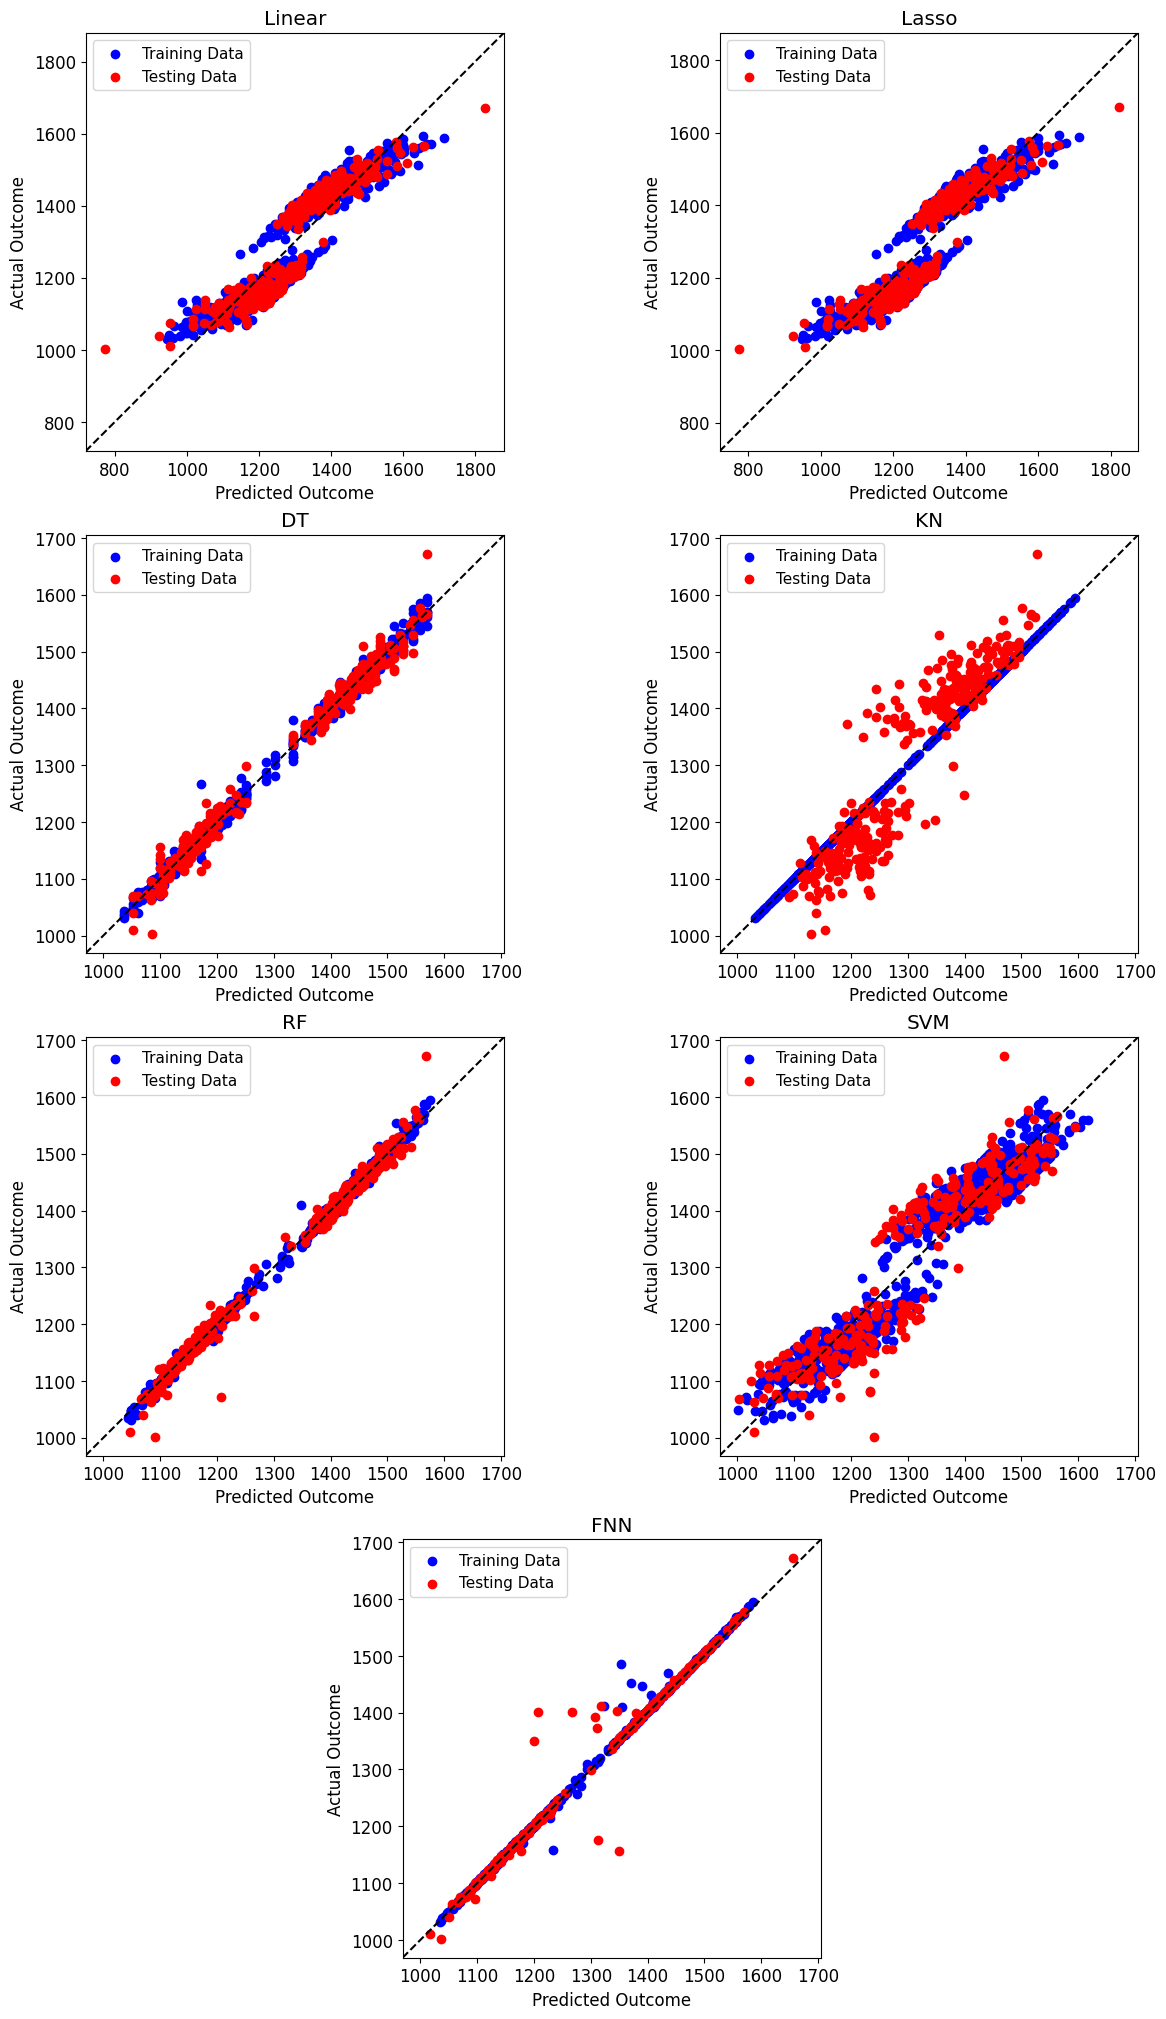

In [27]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")

The performance differences between `RF`/`DT` with the other models are apparent along with the overfitting of `KN`. The `RF` and `DT` predictions are closely spread along $y=x$ while the `KN` test predictions are over-predicted at lower temperatures and under-predicted at higher temperatures.

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots showing each prediction's absolute relative error.

Text(0.5, 1.0, 'FNN')

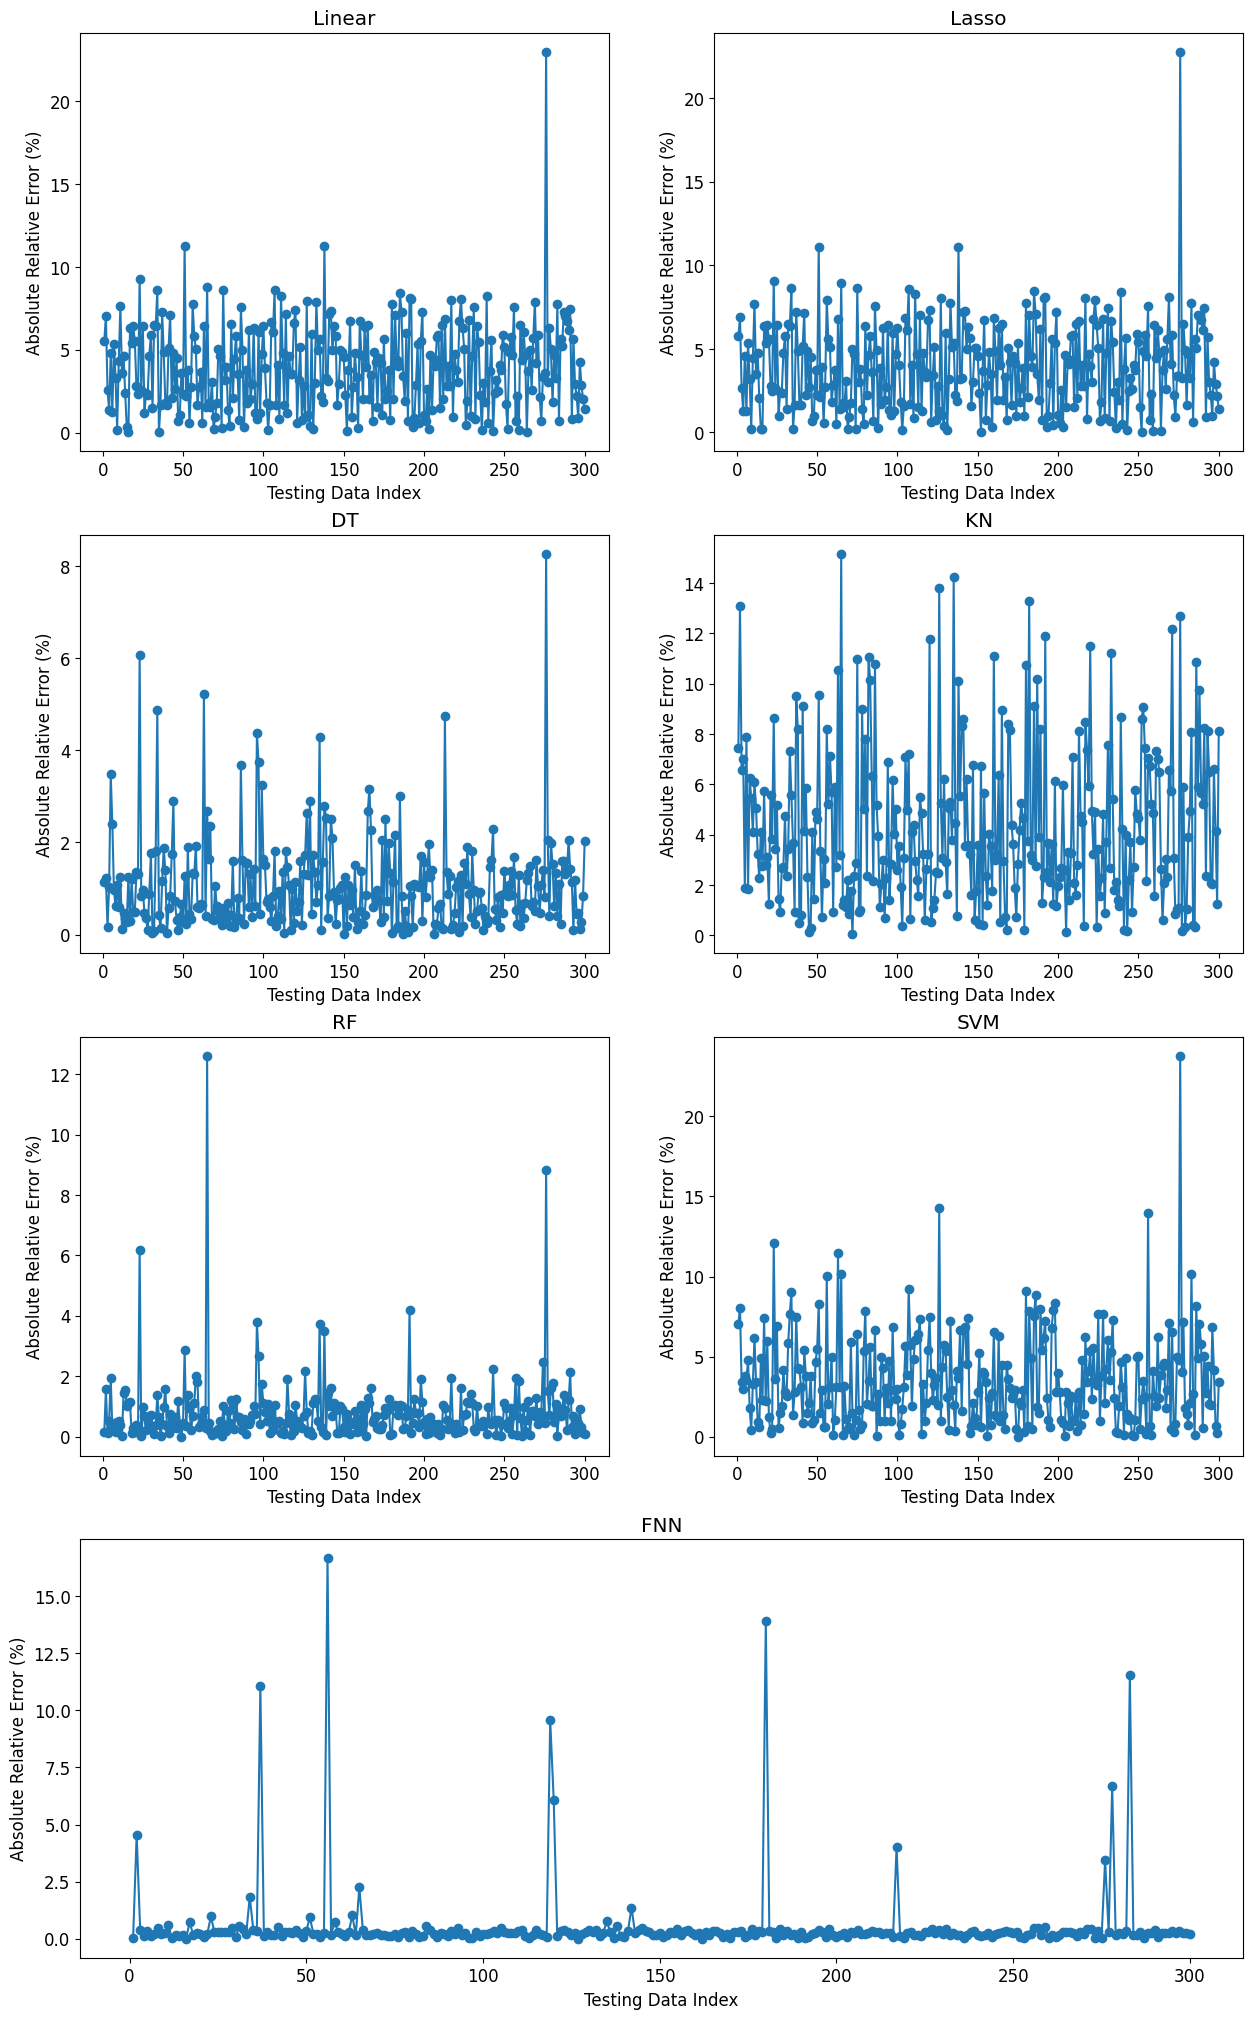

In [28]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `RF` gets as high as $>10.0\%$ error. 

Finally, the most performant `FNN` learning curve is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

<Axes: xlabel='Epoch', ylabel='Loss'>

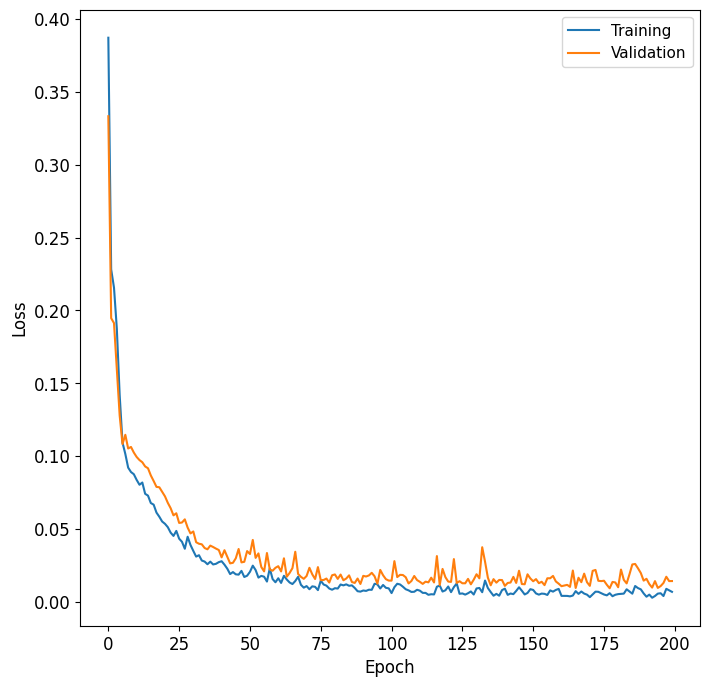

In [29]:
postprocessor.nn_learning_plot()

From the learning curve we can see the top performing neural network based on test $R^2$ is slightly overfit with validation above training.

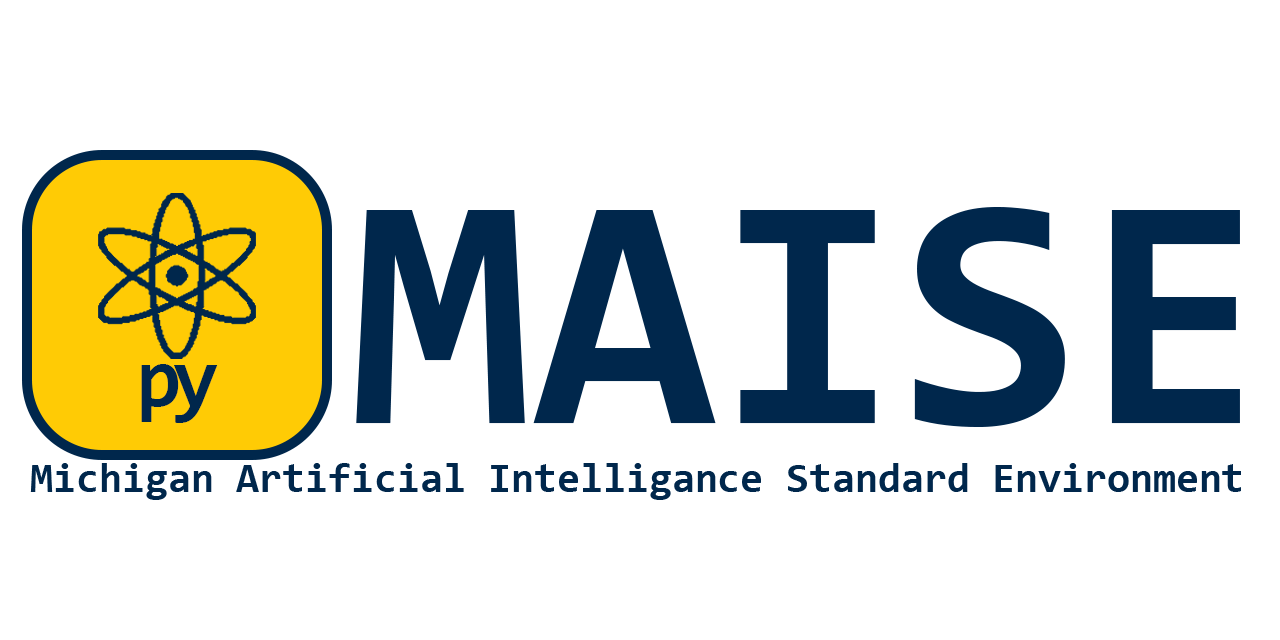